In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython as ip
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
mpl.style.use('ggplot')
mpl.rc('figure', figsize=(7.2, 5.76))
mpl.rc('font', family='Noto Sans CJK TC')
plt.rc('lines', markeredgecolor='white', markeredgewidth=0.75)
plt.rc('patch', edgecolor='white', force_edgecolor=True, linewidth=1)
ip.display.set_matplotlib_formats('svg')

In [3]:
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import pipeline
from sklearn import svm
from sklearn import neighbors
from sklearn import ensemble
from sklearn import metrics

In [4]:
m = sm.datasets.anes96
df = m.load_pandas().data
df_raw = df

In [5]:
df = df_raw
df_X = df[[c for c in df.columns if c != 'vote']]
s_y = df.vote
X_raw = df_X.values
y_raw = s_y.values

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_raw, y_raw, test_size=0.4, random_state=20200503
)

In [7]:
def get_pipe_name(pipe):
    return '-'.join(s[0] for s in pipe.steps)

In [8]:
pipes = [
    pipeline.make_pipeline(
        preprocessing.StandardScaler(),
        svm.LinearSVC(random_state=20200503),
    ),
    pipeline.make_pipeline(
        preprocessing.MinMaxScaler(),
        svm.LinearSVC(random_state=20200503),
    ),
    pipeline.make_pipeline(
        preprocessing.MinMaxScaler(),
        neighbors.KNeighborsClassifier(),
    ),
    pipeline.make_pipeline(
        preprocessing.MinMaxScaler(),
        svm.SVC(kernel='rbf', random_state=20200503),
    ),
    pipeline.make_pipeline(
        ensemble.RandomForestClassifier(random_state=20200503),
    ),
    pipeline.make_pipeline(
        ensemble.GradientBoostingClassifier(random_state=20200503),
    ),
    pipeline.make_pipeline(
        feature_selection.SelectKBest(feature_selection.f_classif, k=3),
        preprocessing.MinMaxScaler(),
        svm.LinearSVC(random_state=20200503),
    ),
    pipeline.make_pipeline(
        feature_selection.SelectKBest(feature_selection.f_classif, k=3),
        preprocessing.MinMaxScaler(),
        neighbors.KNeighborsClassifier(),
    ),
    pipeline.make_pipeline(
        feature_selection.SelectKBest(feature_selection.f_classif, k=3),
        preprocessing.MinMaxScaler(),
        svm.SVC(kernel='rbf', random_state=20200503),
    ),
    pipeline.make_pipeline(
        feature_selection.SelectKBest(feature_selection.f_classif, k=3),
        ensemble.RandomForestClassifier(random_state=20200503),
    ),
    pipeline.make_pipeline(
        feature_selection.SelectKBest(feature_selection.f_classif, k=3),
        ensemble.GradientBoostingClassifier(random_state=20200503),
    ),
]

pipe_name_to_pipe_map = dict(zip(map(get_pipe_name, pipes),
                                 pipes))

In [9]:
cv_list = [
    model_selection.cross_validate(pipe, X_train, y_train,
                                   return_train_score=True)
    for pipe in pipes
]
cv_list_1 = cv_list

Check the overall performances:

,pipe_name,n,fit_time,score_time,test_score,train_score
0,standardscaler-linearsvc,0,0.008347,0.000485,0.929825,0.922566
1,standardscaler-linearsvc,1,0.009326,0.000593,0.876106,0.929360
2,standardscaler-linearsvc,2,0.004213,0.000351,0.902655,0.924945
3,standardscaler-linearsvc,3,0.008128,0.000536,0.964602,0.909492
4,standardscaler-linearsvc,4,0.005667,0.000354,0.876106,0.931567
...,...,...,...,...,...,...
50,selectkbest-gradientboostingclassifier,0,0.064058,0.000874,0.938596,0.951327
51,selectkbest-gradientboostingclassifier,1,0.064447,0.000800,0.884956,0.958057
52,selectkbest-gradientboostingclassifier,2,0.061945,0.000838,0.929204,0.953642
53,selectkbest-gradientboostingclassifier,3,0.061540,0.000779,0.973451,0.944812


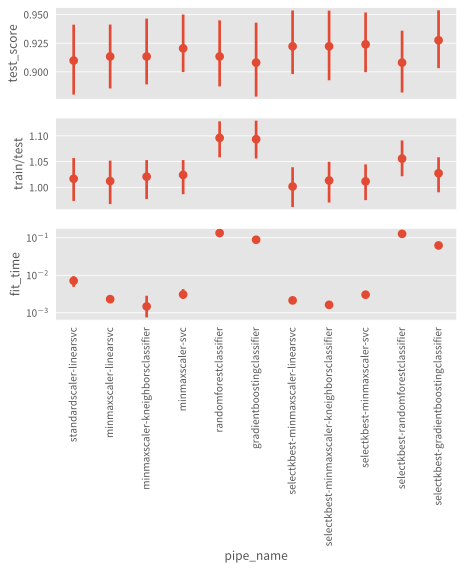

In [10]:
df = pd.concat(map(pd.DataFrame, cv_list_1),
               keys=map(get_pipe_name, pipes),
               names=['pipe_name', 'n'])
df = df.reset_index()
with pd.option_context('display.max_rows', 10):  # just tl;dr
    display(df)
cv_1_df = df

fig, (ax_1, ax_2, ax_3) = plt.subplots(3, 1, sharex=True)

sns.pointplot(data=df, x='pipe_name', y='test_score', join=False, ax=ax_1)
ax_1.set_xlabel('')

# check for overfitting: the train/test should be around 1
sns.pointplot(data=df, x='pipe_name', y=df.train_score/df.test_score, join=False, ax=ax_2)
ax_2.set_xlabel('')
ax_2.set_ylabel('train/test')

sns.pointplot(data=df, x='pipe_name', y='fit_time', join=False, ax=ax_3)
ax_3.set_yscale('log')

plt.xticks(rotation=90)
plt.show()

Select the best pipeline by _test_score/fit_time_:

In [11]:
df = cv_1_df
df = (df
      .groupby('pipe_name')
      [['test_score', 'fit_time']]
      .mean())
df = df.assign(score_per_time=df.test_score/df.fit_time)
df = df.sort_values('score_per_time')
display(df)

pipe_name = df.index[-1]
pipe = pipe_name_to_pipe_map[pipe_name]

pipe.fit(X_train, y_train)
y_test_hat = pipe.predict(X_test)

print(f'The final testing set metrics of the best pipeline ({pipe_name}):\n')
print(metrics.classification_report(y_test, y_test_hat))

,test_score,fit_time,score_per_time
pipe_name,,,
randomforestclassifier,0.913399,0.134077,6.812515
selectkbest-randomforestclassifier,0.908073,0.127271,7.134935
gradientboostingclassifier,0.908089,0.088594,10.250052
selectkbest-gradientboostingclassifier,0.927542,0.062462,14.849786
standardscaler-linearsvc,0.909859,0.007136,127.498164
minmaxscaler-svc,0.920494,0.003084,298.516280
selectkbest-minmaxscaler-svc,0.924034,0.003044,303.584217
minmaxscaler-linearsvc,0.913399,0.002310,395.420510
selectkbest-minmaxscaler-linearsvc,0.922264,0.002144,430.178822


The final testing set metrics of the best pipeline (minmaxscaler-kneighborsclassifier):

              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90       226
         1.0       0.83      0.91      0.87       152

    accuracy                           0.89       378
   macro avg       0.88      0.89      0.89       378
weighted avg       0.89      0.89      0.89       378



Try if _precision_ or _recall_ is more important:

In [12]:
# metrics.SCORERS.keys()
# metrics.SCORERS['precision_macro']
# # -> make_scorer(precision_score, average=binary)

cv_list = [
    model_selection.cross_validate(pipe, X_train, y_train,
                                   scoring=['precision', 'recall', 'accuracy'])
    for pipe in pipes
]

df = pd.concat(map(pd.DataFrame, cv_list),
               keys=map(get_pipe_name, pipes),
               names=['pipe_name', 'n'])
df = df.reset_index()

df = (df
      .groupby('pipe_name')
      [['test_precision', 'test_recall', 'test_accuracy']]
      .mean())

df = df.sort_values(['test_precision', 'test_recall'])

print('If precision is more important:')
display(df.tail(3))

df = df.sort_values(['test_recall', 'test_precision'])

print('If recall is more important:')
display(df.tail(3))

If precision is more important:


,test_precision,test_recall,test_accuracy
pipe_name,,,
selectkbest-minmaxscaler-svc,0.907169,0.916922,0.924034
selectkbest-minmaxscaler-kneighborsclassifier,0.909555,0.908588,0.922279
selectkbest-gradientboostingclassifier,0.921173,0.908588,0.927542


If recall is more important:


,test_precision,test_recall,test_accuracy
pipe_name,,,
minmaxscaler-svc,0.899383,0.916922,0.920494
selectkbest-minmaxscaler-svc,0.907169,0.916922,0.924034
minmaxscaler-kneighborsclassifier,0.879994,0.925255,0.913414
